In [1]:
%matplotlib inline
import pandas as pd
import datetime
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import numpy as np

### Reading CSV file and dropping unnecessary data

In [95]:
df = pd.read_csv('../data/annotated_csv/_2016-11-23-18-49-13_exp2_Player.csv', names = ['time','Control','High_level','Expectation','Activity','linear_acc.x','linear_acc.y','linear_acc.z','gyro.z','gyro.x','gyro.y','ci','distance','proximity'], skiprows = [0])
df.drop(['ci', 'distance', 'Control', 'Expectation', 'Activity', 'proximity'], axis = 1, inplace = True)
print(df.head())

       time High_level  linear_acc.x  linear_acc.y  linear_acc.z  gyro.z  \
0  0.000000  Sprinting       -1583.0        1276.0        2118.0    -6.0   
1  0.000000  Sprinting       -1583.0        1276.0        2118.0    -6.0   
2  0.019987  Sprinting       -1963.0        1402.0        1916.0    -7.0   
3  0.041118  Sprinting       -1898.0        1442.0        1848.0   -10.0   
4  0.057002  Sprinting       -1566.0        1408.0        1672.0   -14.0   

   gyro.x  gyro.y  
0     5.0    -1.0  
1     5.0    -1.0  
2    12.0     5.0  
3    13.0    11.0  
4    12.0    18.0  


### Dropping empty rows (where IMU data is missing)

4113
      index       time High_level  linear_acc.x  linear_acc.y  linear_acc.z  \
0         0   0.000000  Sprinting       -1583.0        1276.0        2118.0   
1         1   0.000000  Sprinting       -1583.0        1276.0        2118.0   
2         2   0.019987  Sprinting       -1963.0        1402.0        1916.0   
3         3   0.041118  Sprinting       -1898.0        1442.0        1848.0   
4         4   0.057002  Sprinting       -1566.0        1408.0        1672.0   
5         6   0.077137  Sprinting        -713.0        1247.0         713.0   
6         7   0.097631  Sprinting        -452.0        1322.0         294.0   
7         8   0.118811  Sprinting        -337.0        1490.0          62.0   
8        10   0.138916  Sprinting        -436.0        2136.0          26.0   
9        11   0.158867  Sprinting        -610.0        2345.0         235.0   
10       12   0.180109  Sprinting       -1094.0        2216.0        1318.0   
11       13   0.200353  Sprinting       -1255.0

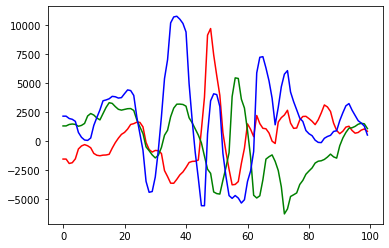

In [96]:
df['linear_acc.x'].replace('', np.nan, inplace = True)
df.dropna(subset = ['linear_acc.x'], inplace = True)
df = df.reset_index()
num = range(100)
plt.plot(num, df['linear_acc.x'][ : 100], 'r', num, df['linear_acc.y'][ : 100], 'g', num, df['linear_acc.z'][ : 100], 'b')
print(len(df))
# print(df)

### Plotting one full game accelerometer data in a grid with each plot having 100 samples and title being the annotation at the centre of each 100 examples.

6


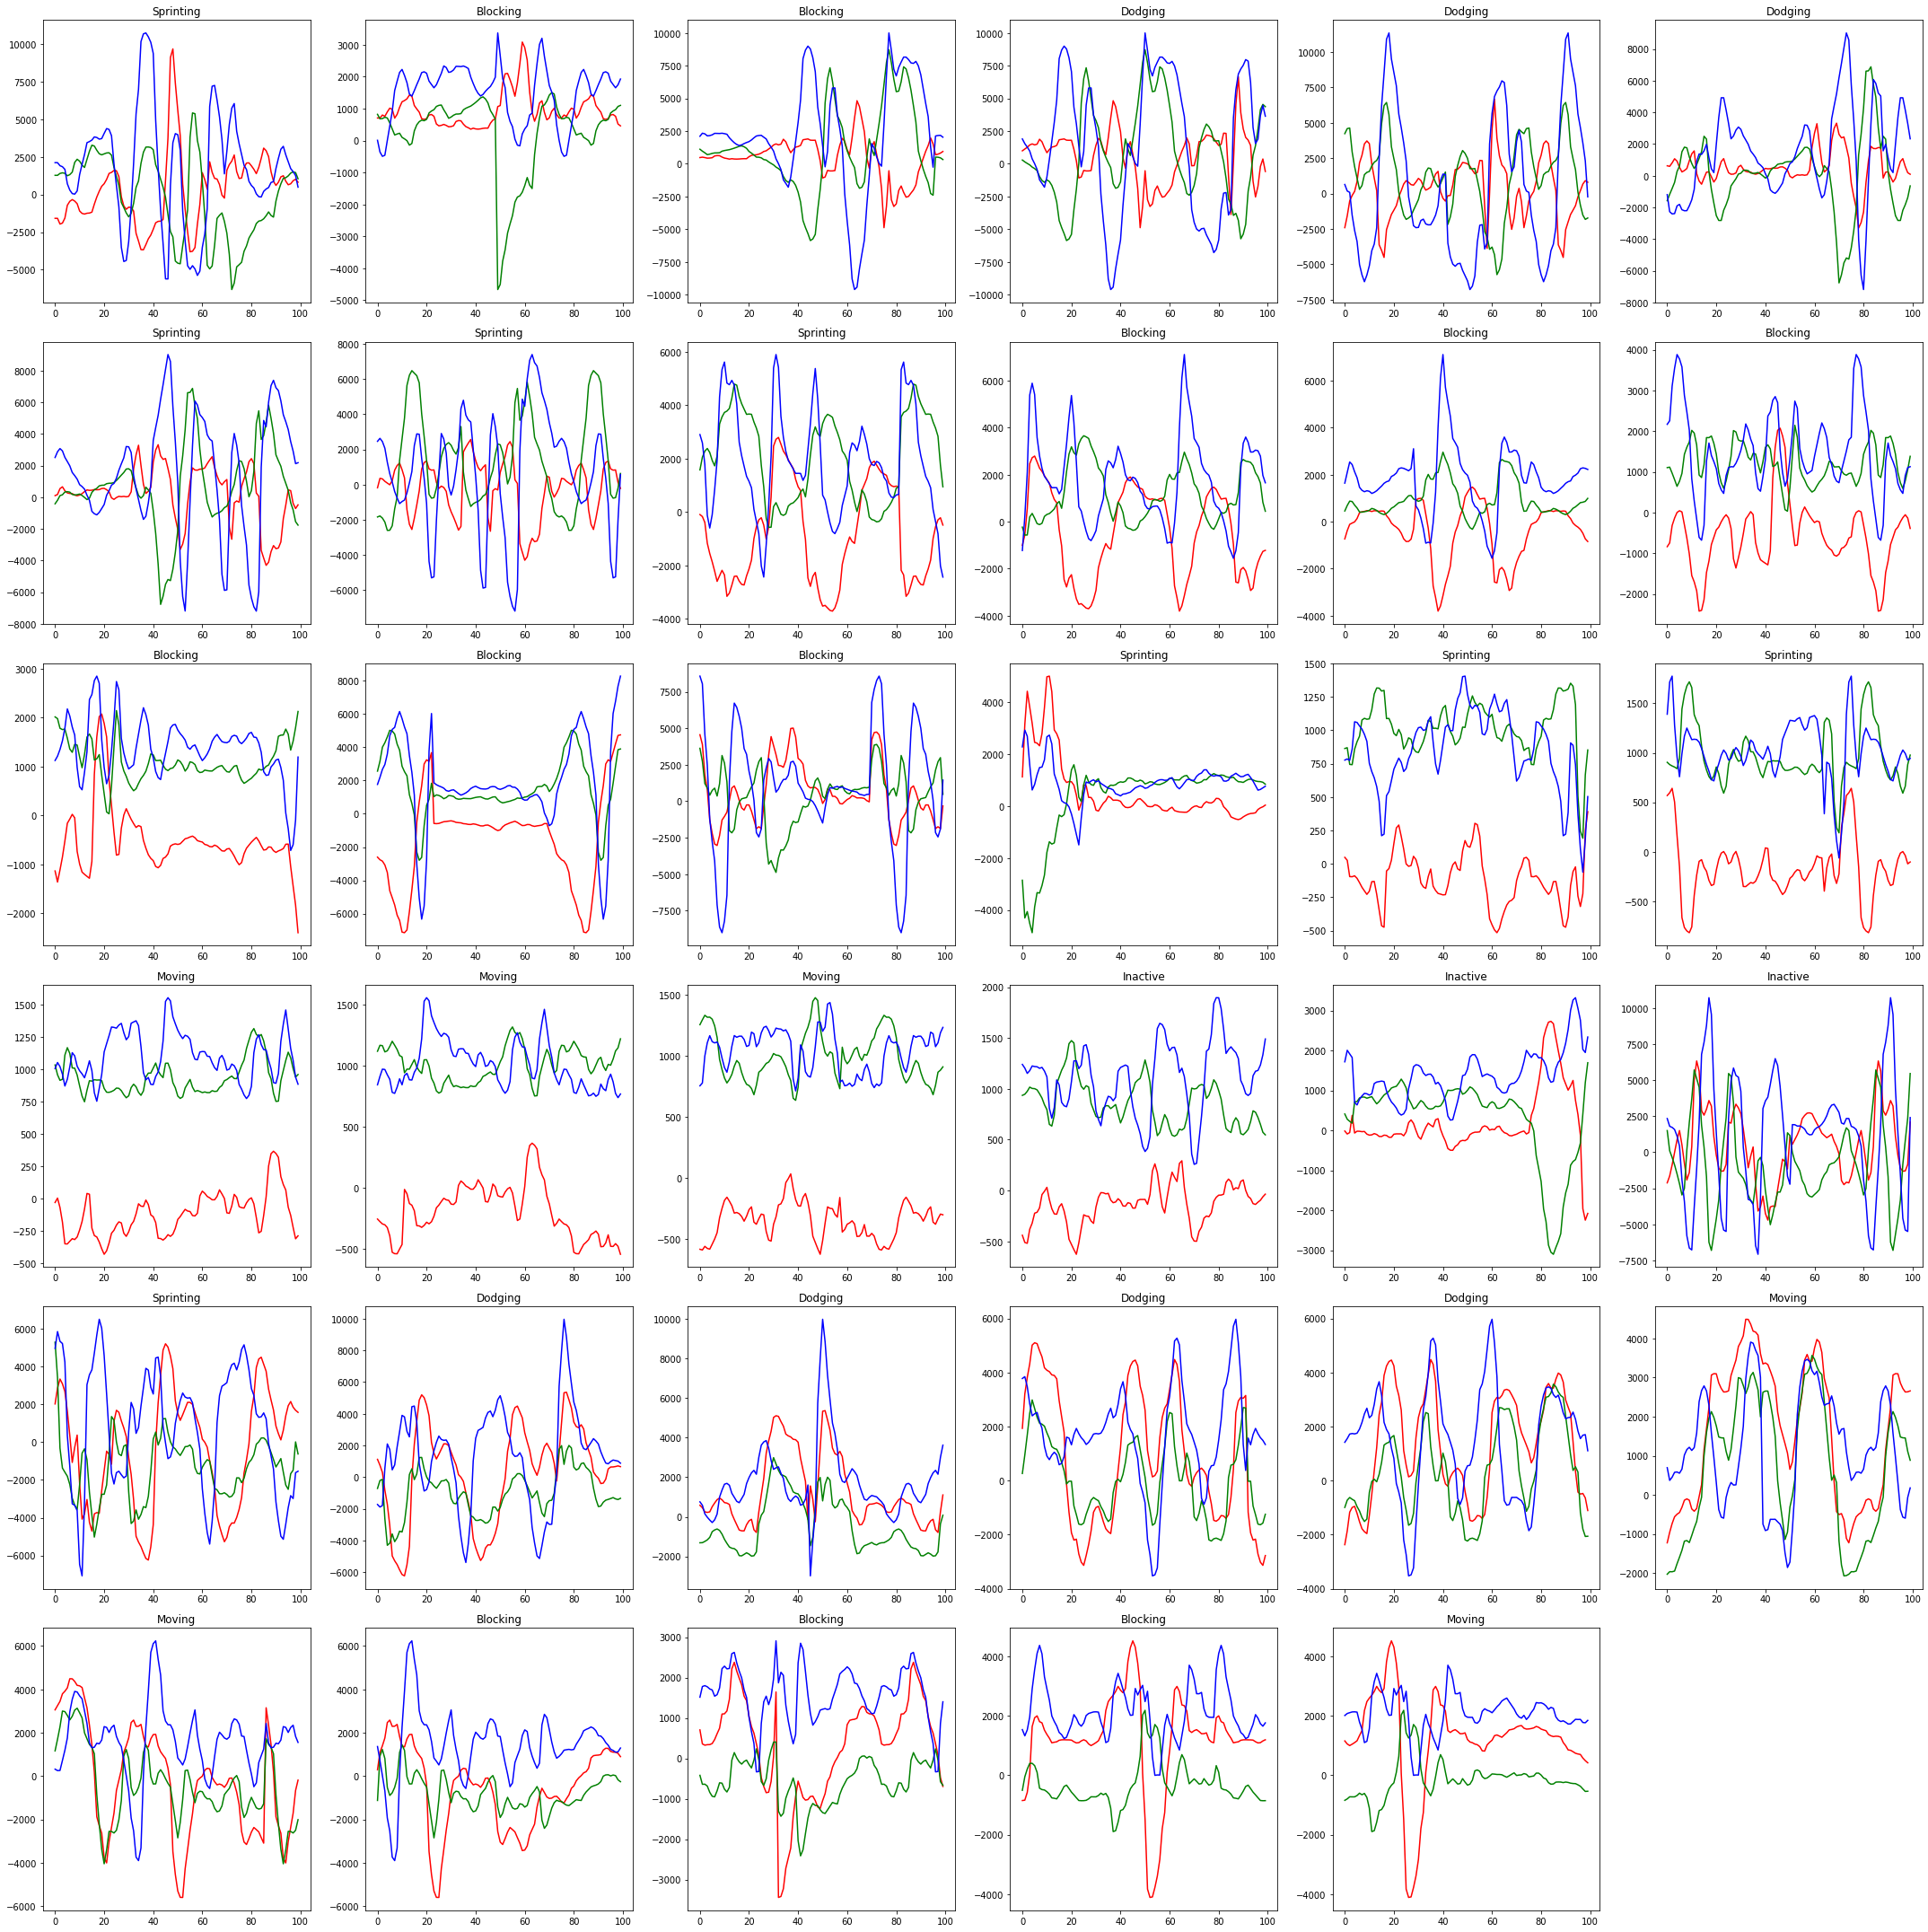

In [151]:
fig = plt.figure()
fig.set_figheight(30)
fig.set_figwidth(30)
fig.subplots_adjust(hspace = 1, wspace = 1)
num = range(100)
grid_size = int(np.round(np.sqrt(len(df) / 100)))
print(grid_size)
for i in range(1, grid_size * grid_size):
    ax = fig.add_subplot(grid_size, grid_size, i)
    # setting title to be central label
    ax.set_title(str(df['High_level'][((i - 1) * 100) + 50]))
    ax.plot(num, df['linear_acc.x'][(i - 1) * 100 : i * 100], 'r', num, df['linear_acc.y'][(i - 1) * 100 : i * 100], 'g', num, df['linear_acc.z'][(i - 1) * 100 : i * 100], 'b')
    
fig.tight_layout()
plt.show()

### Converting each data stream into NumPy Arrays for further processing

In [152]:
# separate out different data streams (x_acc, y_acc, etc.) into different numpy arrays
# and normalizing accelerometer readings by dividing by a factor of 16384 
# (converting into multiples of g (9.8 m/s^2)) (According to Invensense MPU 6050 datasheet)
x_acc = np.asarray(df['linear_acc.x']) / 16384.0
y_acc = np.asarray(df['linear_acc.y']) / 16384.0
z_acc = np.asarray(df['linear_acc.z']) / 16384.0
x_gyro = np.asarray(df['gyro.x'])
y_gyro = np.asarray(df['gyro.y'])
z_gyro = np.asarray(df['gyro.z'])
labels = np.asarray(df['High_level'])
all_data = df.to_numpy()
print(all_data.shape)

# check for issues (won't get assertion error if no issues)
assert(len(x_acc) == len(z_gyro))
assert(len(y_acc) == len(x_gyro))

(4113, 9)


### Determining various features in a sliding window over the signal

In [161]:
def running_mean(x, window_size = 10):
    ''' Returns running mean of x calculated using a window of size window_size
    Sliding of window starts from zero index upto where window can be placed (len(x) - window_size)
    Remaining part of running_mean output (very small part) is same as the original signal
    '''
    mean = np.zeros_like(x)
    for i in range(len(x) - window_size):
        mean[i] = np.mean(x[i : i + window_size])
    
    for i in range(len(x) - window_size, len(x)):
        mean[i] = x[i]
        
    return mean

def running_std_deviation(x, window_size = 10):
    ''' Returns running standard deviation of x calculated using a window of size window_size
    Sliding of window starts from zero index upto where window can be placed (len(x) - window_size)
    Remaining part of running_mean output (very small part) is same as the original signal
    '''
    std_dev = np.zeros_like(x)
    for i in range(len(x) - window_size):
        std_dev[i] = np.std(x[i : i + window_size])
        
    for i in range(len(x) - window_size, len(x)):
        std_dev[i] = x[i]
        
    return std_dev

x_acc_mean = running_mean(x_acc, window_size = 10)
y_acc_mean = running_mean(y_acc, window_size = 10)
z_acc_mean = running_mean(z_acc, window_size = 10)

x_acc_std = running_std_deviation(x_acc, window_size = 10)
y_acc_std = running_std_deviation(y_acc, window_size = 10)
z_acc_std = running_std_deviation(z_acc, window_size = 10)

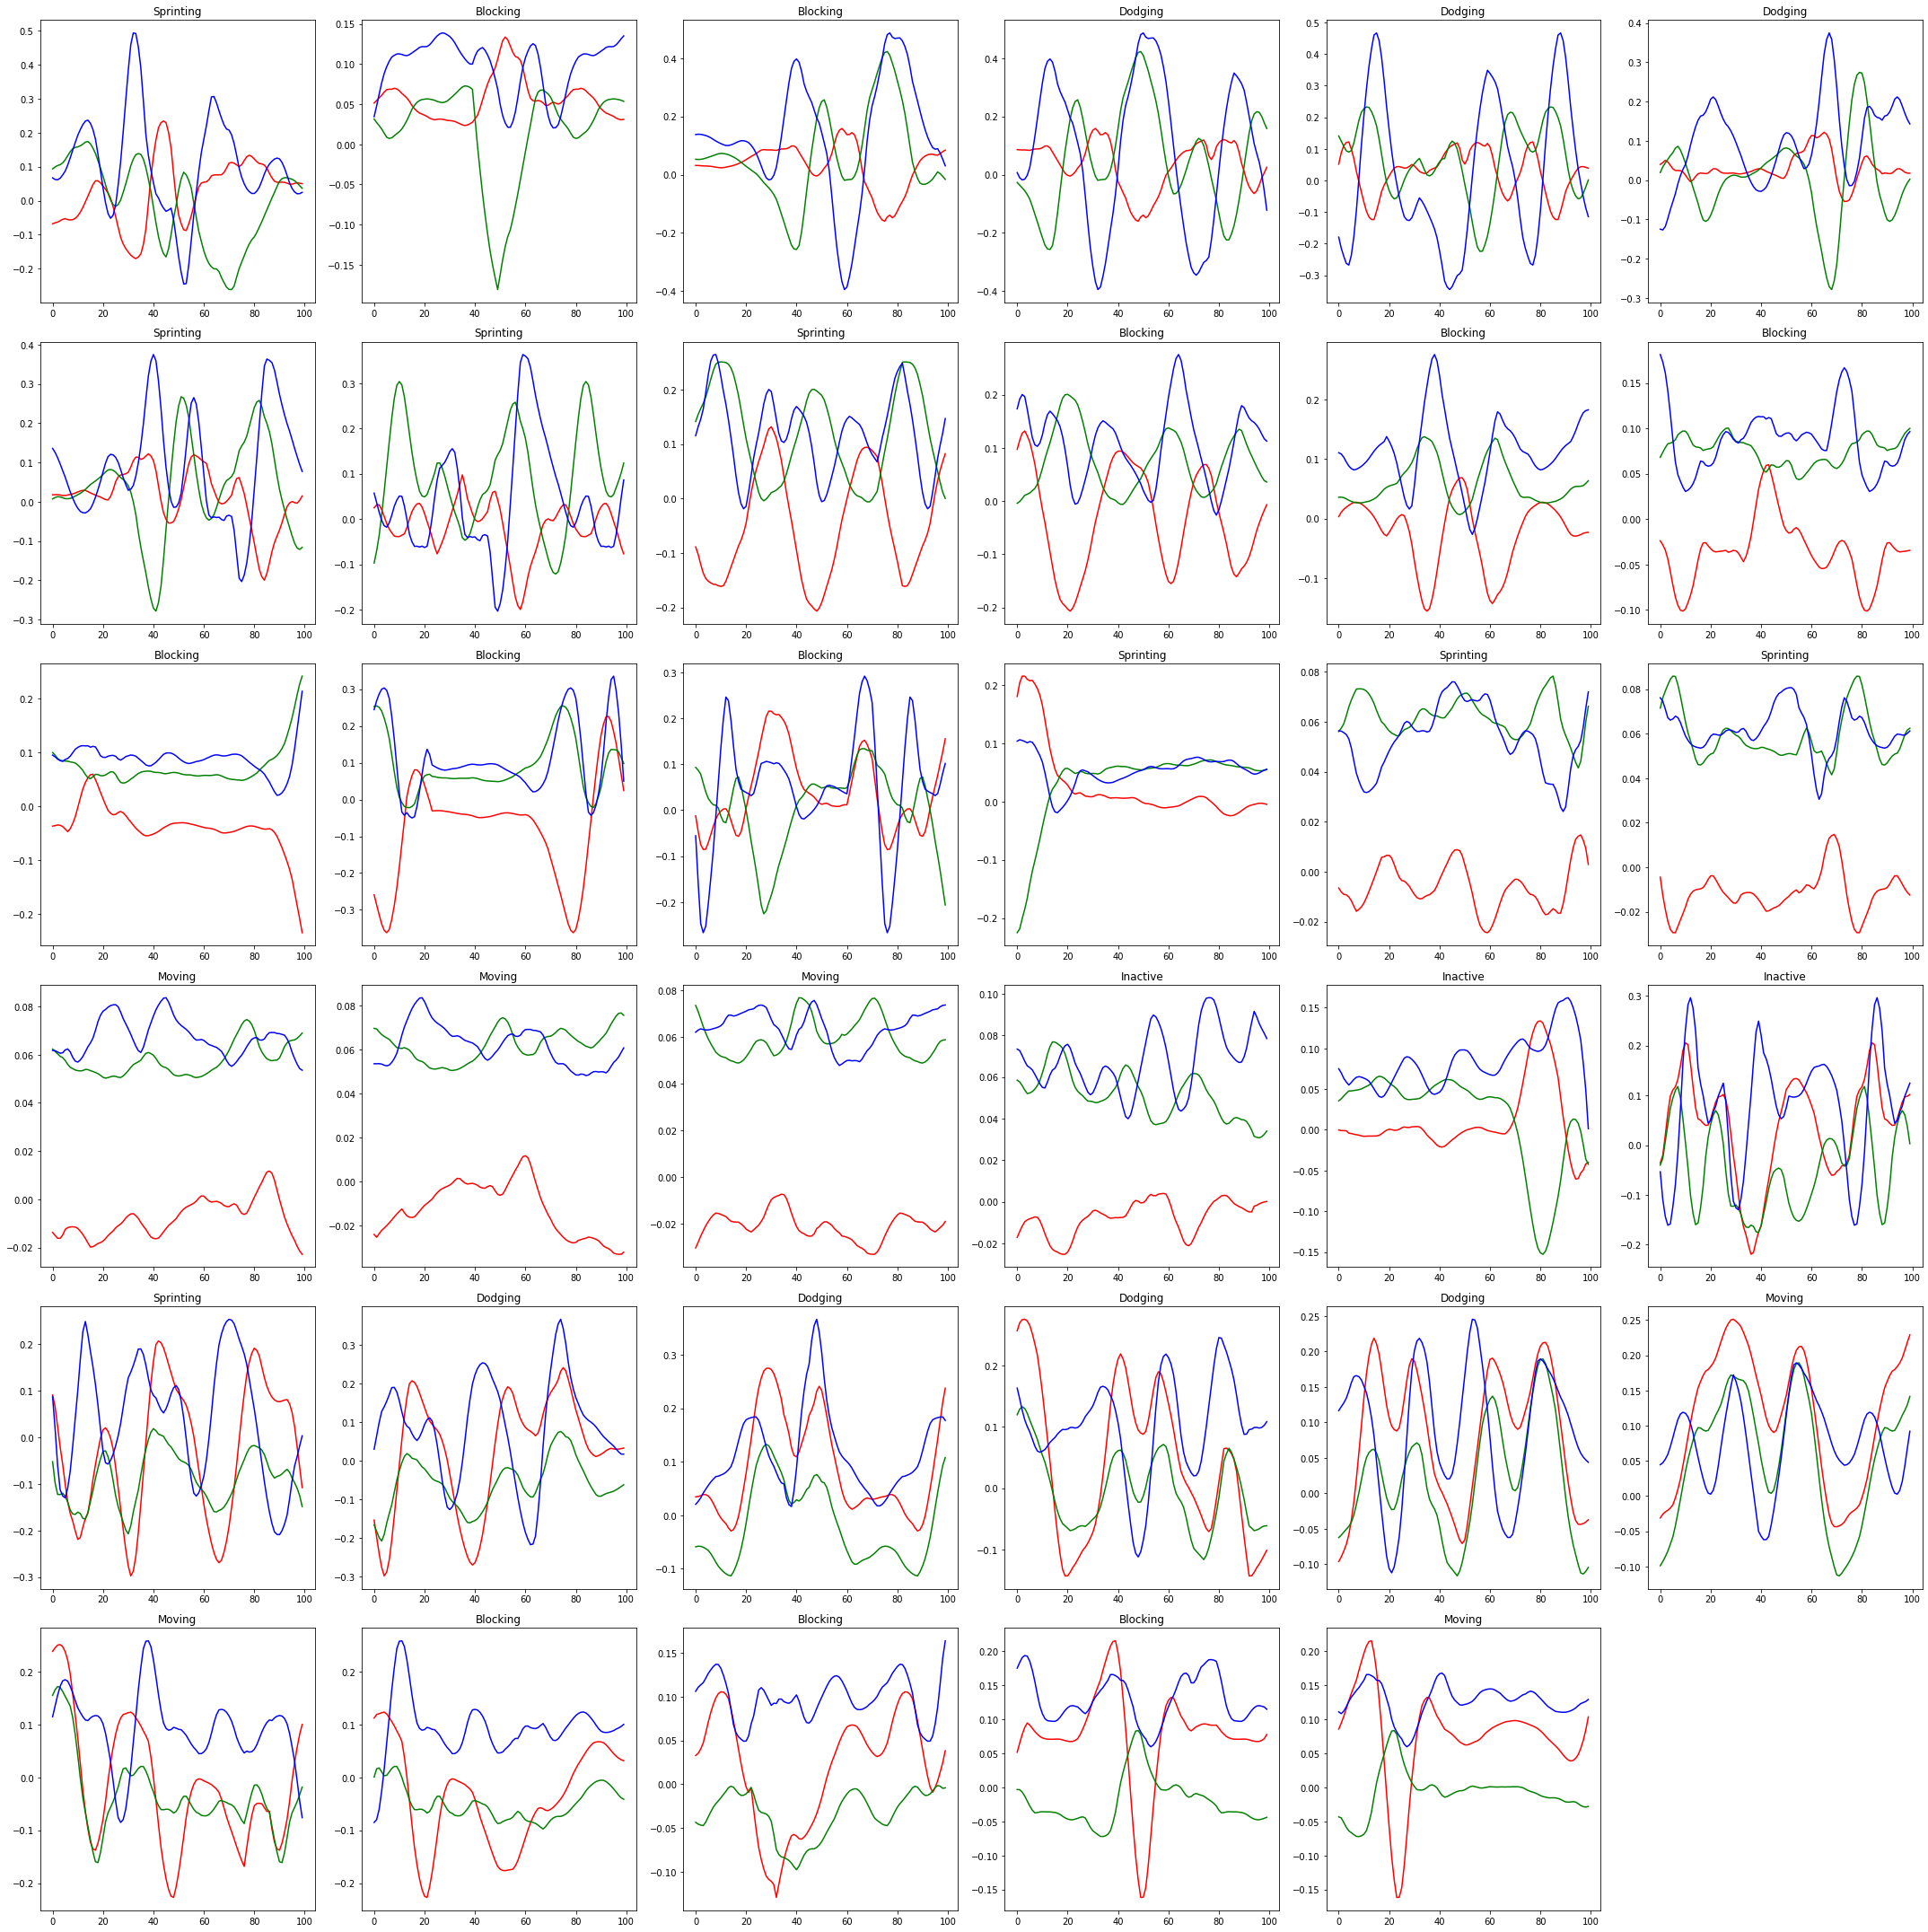

In [158]:
def plotData(data):
    x_, y_, z_ = data
    fig = plt.figure()
    fig.set_figheight(30)
    fig.set_figwidth(30)
    fig.subplots_adjust(hspace = 1, wspace = 1)
    num = range(100)
    grid_size = int(np.round(np.sqrt(len(df) / 100)))
    for i in range(1, grid_size ** 2):
        ax = fig.add_subplot(grid_size, grid_size, i)
        # setting title to be central label
        ax.set_title(labels[(i - 1) * 100 + 50])
        ax.plot(num, x_[(i - 1) * 100 : i * 100], 'r', num, y_[(i - 1) * 100 : i * 100], 'g', num, z_[(i - 1) * 100 : i * 100], 'b')
        
    fig.tight_layout()
    plt.show()
    
plotData([x_acc_mean, y_acc_mean, z_acc_mean])
# plotData([x_acc, y_acc, z_acc])

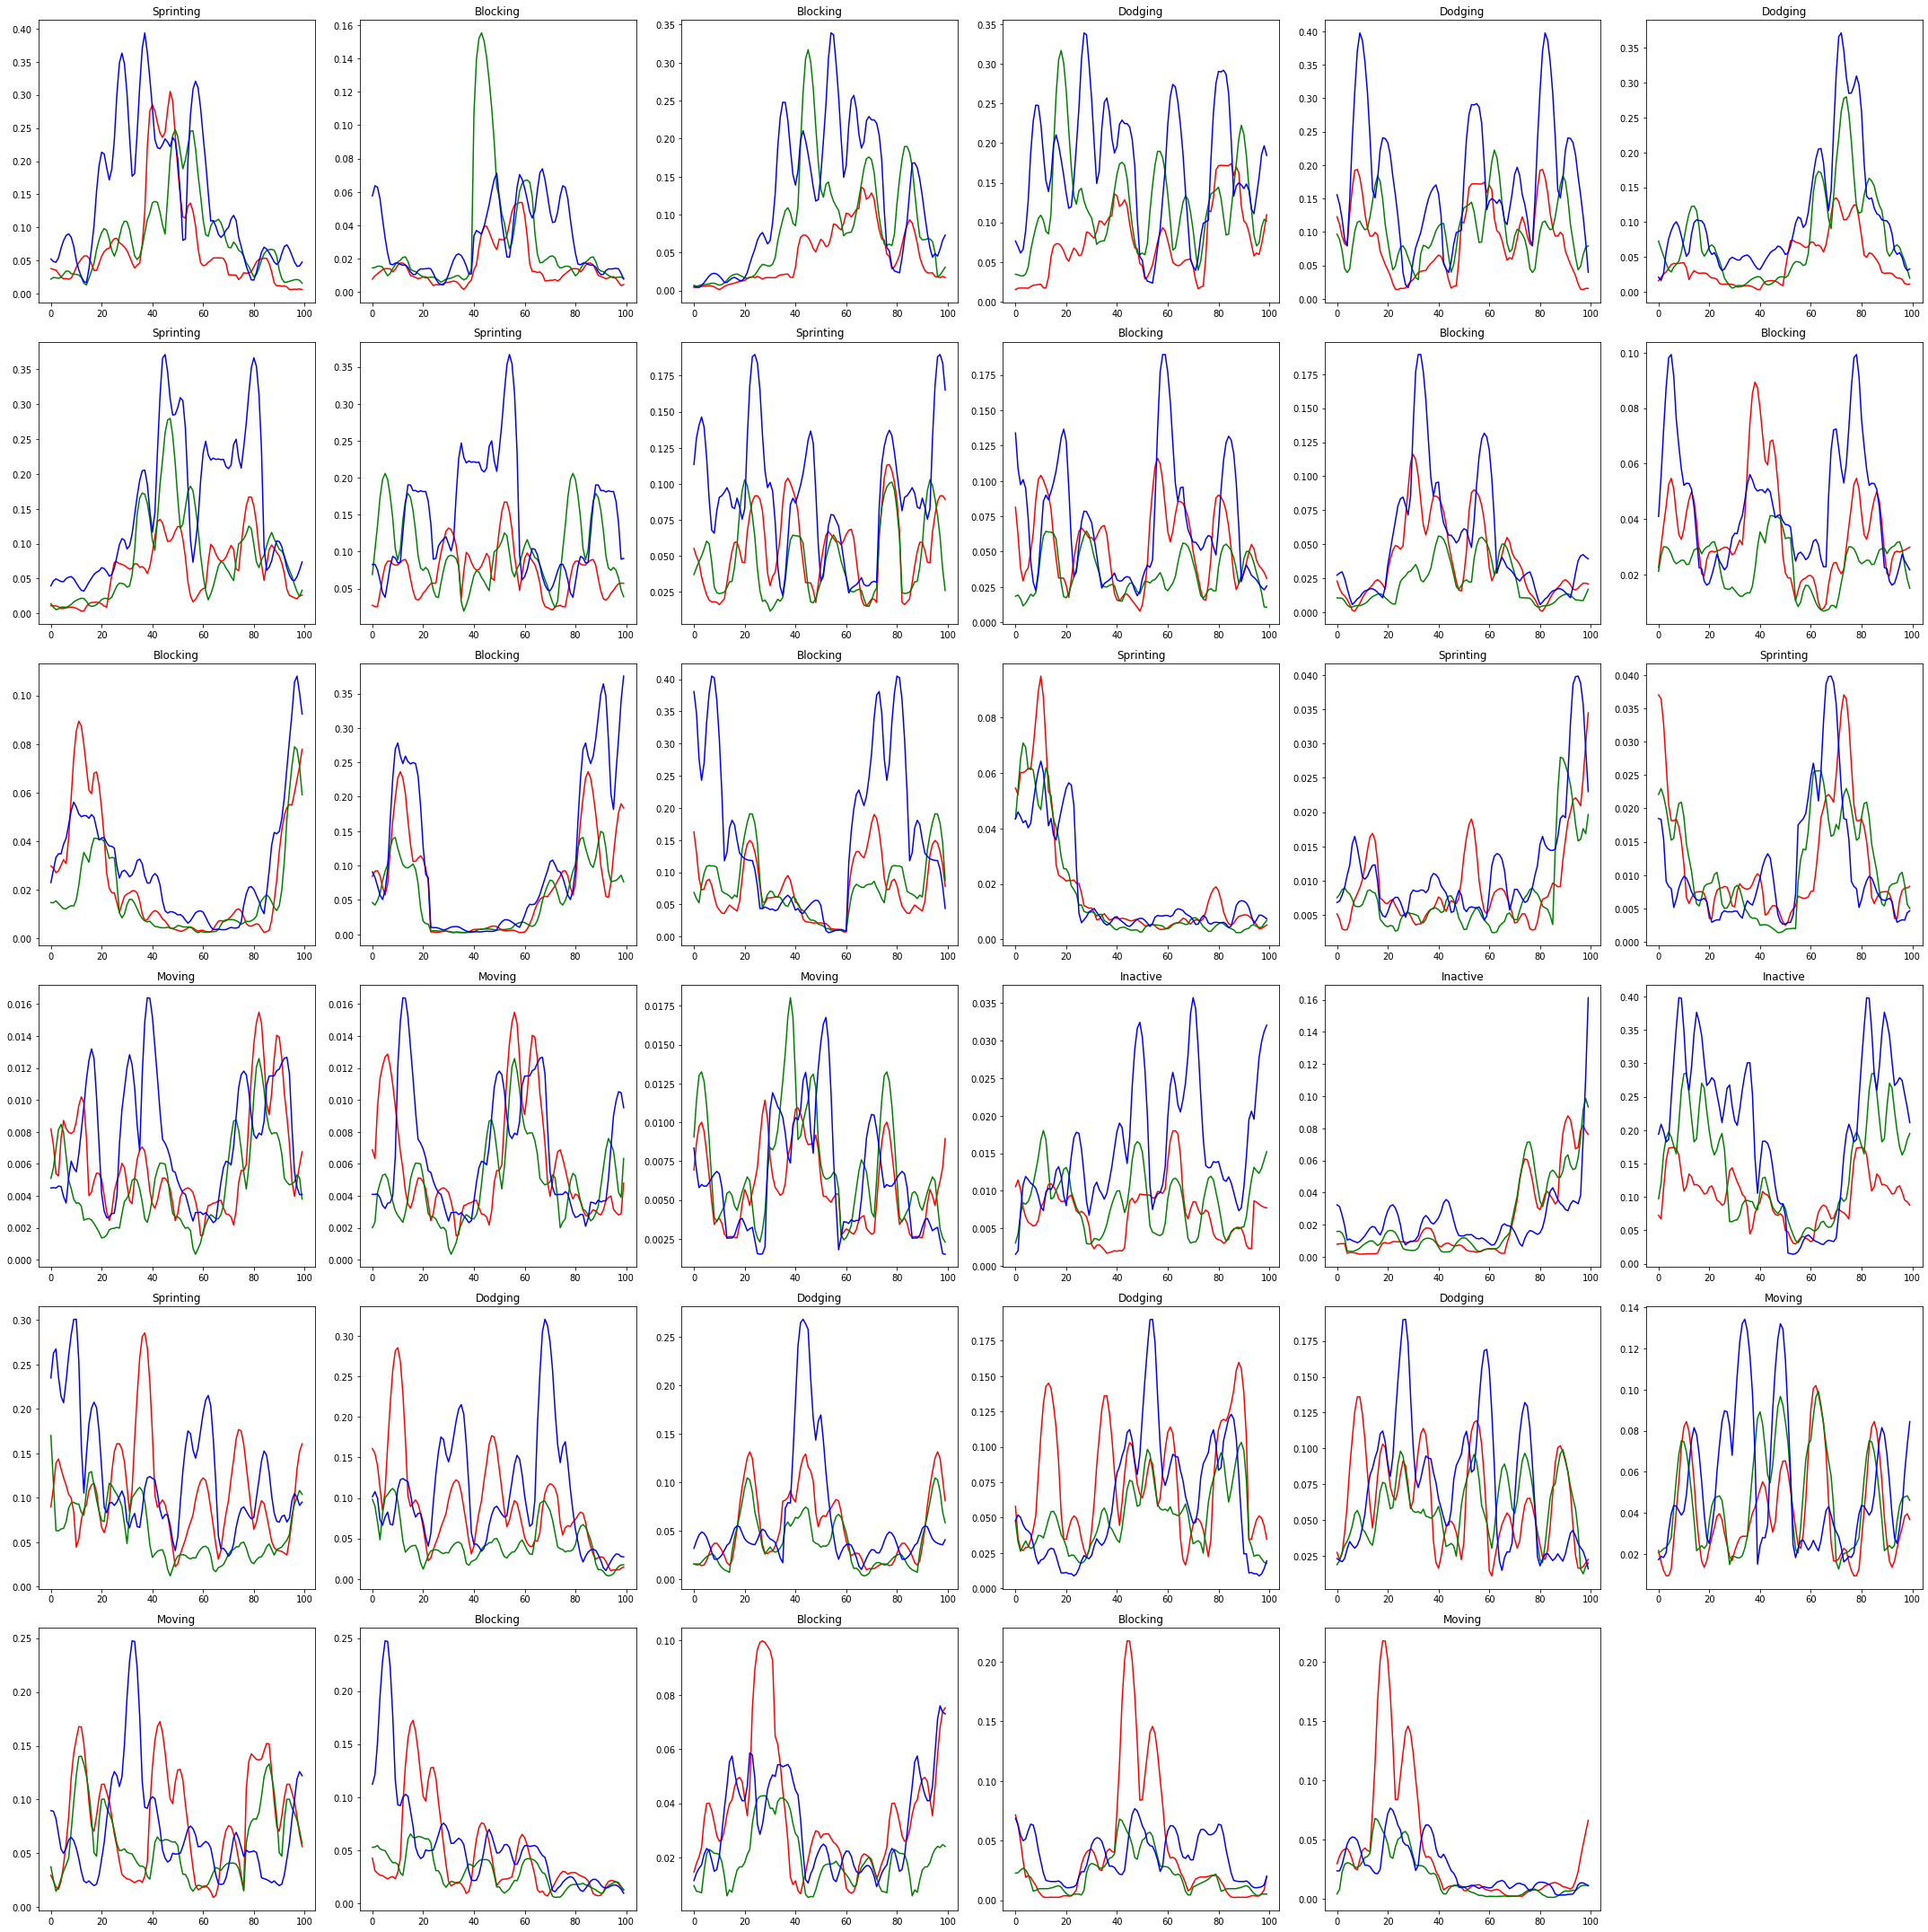

In [162]:
plotData([x_acc_std, y_acc_std, z_acc_std])